In [19]:
import os
import time
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
torch.manual_seed(42)

from models.CNN import CNN
from dataset import Agulhas3
from joint_transforms import Transform2
from utils import save_checkpoint, load_checkpoint, save_examples3

In [20]:
MODEL = 'CNN'
LEARNING_RATE = 2.0E-4
NUM_EPOCHS = 100
INPUT_SIZE = 256
BATCH_SIZE = 4
GAMMA = 0.5
USE_CHECKPOINT = False

SNAPSHOT_DIR = os.path.join('outputs' , MODEL, 'snapshots')
RESTORE_FROM = os.path.join('outputs', MODEL, 'snapshots')

try:
    os.makedirs(SNAPSHOT_DIR)
    print(SNAPSHOT_DIR)
except FileExistsError:
    pass

outputs/CNN/snapshots


In [21]:
def val_loop(dataloader, transform_params, model, saving_path):

    model.eval()
    with torch.no_grad():
        for counter, (ssh, it, bm) in enumerate(dataloader, 1):

            # GPU deployment
            ssh = ssh.cuda()
            it = it.cuda()
            bm = bm.cuda()

            # Compute prediction and loss
            bm_ = model(ssh)
            it_ = ssh - bm_
            
            y = torch.cat([it, bm], dim=1)
            y_ = torch.cat([it_, bm_], dim=1)

            save_examples3(ssh, y, y_, transform_params, counter, saving_path)
            
            if counter == 5:
                break

def psnr(original, reconstructed):
    
    # R is the maximum fluctuation in the input image data type. [-1, +1] -> 2.0
    mse = F.mse_loss(original, reconstructed)
    psnr = 20 * torch.log10(2.0 / torch.sqrt(mse))

    return psnr

In [22]:
# Without xbatcher
def main():
    
    since = time.time()
    
    cudnn.enabled = True
    cudnn.benchmark = True
    
    print(f"{MODEL} is deployed on {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Loading model
    model = CNN().to(device)

    # Dataloader
    joint_transforms = Transform2()
    
    train_dataset = Agulhas3(split='train', joint_transform=joint_transforms)
    val_dataset = Agulhas3(split='val', joint_transform=joint_transforms)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
    val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True, drop_last=False)

    # Initializing the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=GAMMA)
    
    
    if USE_CHECKPOINT:
        load_checkpoint(f'{RESTORE_FROM}/model.pth.tar', model, optimizer, LEARNING_RATE)
    
    transform_params = train_dataset.transform_dict
    logger = {'loss': list(), 'psnr': list()}
    
    model.train()
    
    for epoch in range(NUM_EPOCHS):
        print('Epoch:', epoch,'LR:', scheduler.get_last_lr())
        
        batch_loss = 0.0
        batch_psnr = 0.0
        for batch_idx, (ssh, it, bm) in enumerate(train_dataloader):

            ssh = ssh.to(device)
            it = it.to(device)
            bm = bm.to(device)

            pred = model(ssh)
            loss = criterion(bm, pred)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss = loss.detach()
            batch_loss += loss.item()
            batch_psnr += psnr(bm.detach(), pred.detach()).cpu().numpy()

            if batch_idx % 140 == 0:
                print(f"Epoch: [{epoch}/{NUM_EPOCHS}] Batch: {batch_idx:>2}/{len(train_dataloader)} "
                      f"Loss: {loss.item():.8f}")

        scheduler.step()
        
        logger['loss'].append(batch_loss / len(train_dataloader))
        logger['psnr'].append(batch_psnr / len(train_dataloader))
        
        current_dir = os.path.join(SNAPSHOT_DIR, f'epoch-{epoch:003d}')
        
        try:
            os.makedirs(current_dir)
        except FileExistsError:
            pass

        val_loop(val_dataloader, transform_params, model, current_dir)
        
        if epoch % 10 == 0:
            save_checkpoint(model, optimizer,  os.path.join(current_dir, "model.pth.tar"))
    
    
    with open(os.path.join(SNAPSHOT_DIR, "logger.npy"), mode = 'wb') as f:
        np.save(f, np.array(logger['loss']))
        np.save(f, np.array(logger['psnr']))



In [23]:
main()

CNN is deployed on Tesla T4
Epoch: 0 LR: [0.0002]
Epoch: [0/100] Batch:  0/723 Loss: 0.19713879
Epoch: [0/100] Batch: 140/723 Loss: 0.00056118
Epoch: [0/100] Batch: 280/723 Loss: 0.00005087
Epoch: [0/100] Batch: 420/723 Loss: 0.00039876
Epoch: [0/100] Batch: 560/723 Loss: 0.00008450
Epoch: [0/100] Batch: 700/723 Loss: 0.00078125
Saving Checkpoint...
Epoch: 1 LR: [0.0002]
Epoch: [1/100] Batch:  0/723 Loss: 0.00044797
Epoch: [1/100] Batch: 140/723 Loss: 0.00041783
Epoch: [1/100] Batch: 280/723 Loss: 0.00010533
Epoch: [1/100] Batch: 420/723 Loss: 0.00069034
Epoch: [1/100] Batch: 560/723 Loss: 0.00019440
Epoch: [1/100] Batch: 700/723 Loss: 0.00013422
Epoch: 2 LR: [0.0002]
Epoch: [2/100] Batch:  0/723 Loss: 0.00053278
Epoch: [2/100] Batch: 140/723 Loss: 0.00024334
Epoch: [2/100] Batch: 280/723 Loss: 0.00008885
Epoch: [2/100] Batch: 420/723 Loss: 0.00012779
Epoch: [2/100] Batch: 560/723 Loss: 0.00036959
Epoch: [2/100] Batch: 700/723 Loss: 0.00032956
Epoch: 3 LR: [0.0002]
Epoch: [3/100] Batch

In [24]:
import xrft
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils import plot_examples
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

In [32]:
def psnr(original, reconstructed):
    
    if isinstance(original, (np.ndarray, np.generic)):
    
        mse = (np.square(original - reconstructed)).mean(axis=(1, 2, 3))
        psnr = 20 * np.log10(2.0 / np.sqrt(mse))
    
    else:
        mse = F.mse_loss(original, reconstructed, reduction='none').mean(dim=(1, 2, 3))
        psnr = 20 * torch.log10(2.0 / torch.sqrt(mse))
    
    return psnr

def ECDF(**kwargs):
    fig, ax = plt.subplots()
    
    for kwarg, value in kwargs.items():
        x = np.sort(value)
        y = np.arange(1, len(value) + 1) / len(value)
        ax.plot(x, y, linestyle='--', alpha=1, label=kwarg)
    
    ax.legend()
    plt.show()

In [26]:
with open(os.path.join(RESTORE_FROM, 'logger.npy'), 'rb') as f:
    loss = np.load(f)
    psnr = np.load(f)

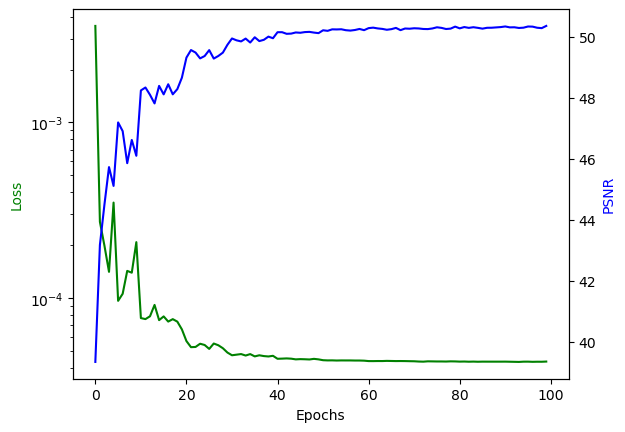

In [27]:
fig, ax1 = plt.subplots()

ax1.semilogy(loss, 'g-')

ax2 = ax1.twinx()
ax2.plot(psnr, 'b-')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('PSNR', color='b')

plt.show()

In [39]:
dataset = Agulhas3(split='val', joint_transform=None)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, drop_last=False)

cudnn.enabled = True
cudnn.benchmark = True

model = CNN().cuda()
load_checkpoint(f'{RESTORE_FROM}/epoch-090/model.pth.tar', model, None, None)

Loading Checkpoint...


In [40]:
inps = np.empty((0, 1, 256, 256))

tars1 = np.empty((0, 1, 256, 256))
tars2 = np.empty((0, 1, 256, 256))

gens1 = np.empty((0, 1, 256, 256))

model.eval()
with torch.no_grad():
    
    loop = tqdm(dataloader, leave=True)
    for counter, (ssh, it, bm) in enumerate(loop, 1):

        # GPU deployment
        ssh = ssh.cuda()
        it = it.cuda()
        bm = bm.cuda()

        # Compute prediction and loss
        g = model(ssh)
        
        inp = ssh.detach().cpu().numpy()
        
        tar1 = bm.detach().cpu().numpy()
        tar2 = it.detach().cpu().numpy()
        
        gen1 = g.detach().cpu().numpy()
        
        inps = np.concatenate((inps, inp), axis=0)
        
        tars1 = np.concatenate((tars1, tar1), axis=0)
        tars2 = np.concatenate((tars2, tar2), axis=0)
        
        gens1 = np.concatenate((gens1, gen1) , axis=0)

print(inps.shape, tars1.shape, tars2.shape, gens1.shape)   

100%|██████████| 413/413 [01:07<00:00,  6.09it/s]

(413, 1, 256, 256) (413, 1, 256, 256) (413, 1, 256, 256) (413, 1, 256, 256)


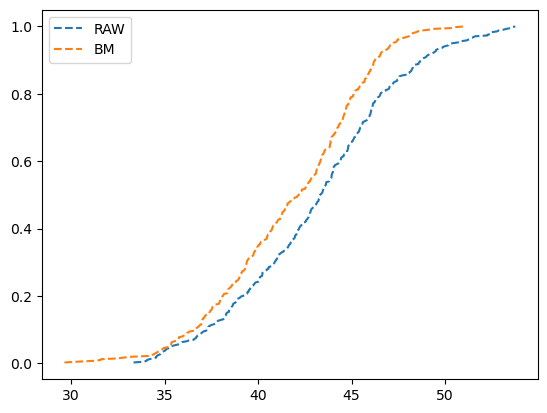

In [33]:
ECDF(RAW=psnr(inps, tars1), BM=psnr(tars1, gens1))

In [34]:
inps = inps + 1 / 2

tars1 = tars1 + 1 / 2
tars2 = tars2 + 1 / 2

gens1 = gens1 + 1 / 2

inps = inps * (dataset.transform_dict['inputs'][1] - dataset.transform_dict['inputs'][0]) + dataset.transform_dict['inputs'][0]

tars1 = tars1 * (dataset.transform_dict['targets_bm'][1] - dataset.transform_dict['targets_bm'][0]) + dataset.transform_dict['targets_bm'][0]
tars2 = tars2 * (dataset.transform_dict['targets_it'][1] - dataset.transform_dict['targets_it'][0]) + dataset.transform_dict['targets_it'][0]

gens1 = gens1 * (dataset.transform_dict['targets_bm'][1] - dataset.transform_dict['targets_bm'][0]) + dataset.transform_dict['targets_bm'][0]

gens2 = inps - gens1

In [35]:
r2 = r2_score(tars1.reshape(413, -1), gens1.reshape(413, -1))
mse = mean_squared_error(tars1.reshape(413, -1), gens1.reshape(413, -1), squared=False)
pbias = 100 * np.sum(gens1 - tars1) / np.sum(tars1)

print('Balanced Motions:')
print(f'R2: {r2:.4f}, PBias: {pbias:.4f}, RMSE: {mse:.4f}')

r2 = r2_score(tars2.reshape(413, -1), gens2.reshape(413, -1))
mse = mean_squared_error(tars2.reshape(413, -1), gens2.reshape(413, -1), squared=False)
pbias = 100 * np.sum(gens2 - tars2) / np.sum(tars2)

print('Internal Tides:')
print(f'R2: {r2:.4f}, PBias: {pbias:.4f}, RMSE: {mse:.4f}')

Balanced Motions:
R2: 0.9997, PBias: -0.2225, RMSE: 0.0592
Internal Tides:
R2: -94.7887, PBias: -661.9730, RMSE: 0.0332


In [36]:
da_rw = xr.DataArray(inps.squeeze(), dims=['z', 'x', 'y'])
da_gt = xr.DataArray(tars1.squeeze(), dims=['z', 'x', 'y'])
da_gn = xr.DataArray(gens1.squeeze(), dims=['z', 'x', 'y'])

ps_rw = xrft.power_spectrum(da_rw, 'x', window='hamming').rename('rw').values
ps_gt = xrft.power_spectrum(da_gt, 'x', window='hamming').rename('gt').values
ps_gn = xrft.power_spectrum(da_gn, 'x', window='hamming').rename('gn').values

r2 = r2_score(ps_gt.reshape(413, -1), ps_gn.reshape(413, -1))
mse = mean_squared_error(ps_gt.reshape(413, -1), ps_gn.reshape(413, -1), squared=False)
pbias = 100 * np.sum(ps_gt - ps_gn) / np.sum(ps_gt)

print('Balanced Motions in Frequencty Domain:')
print(f'R2: {r2:.4f}, PBias: {pbias:.4f}, RMSE: {mse:.4f}')

Balanced Motions in Frequencty Domain:
R2: 0.5743, PBias: 0.4723, RMSE: 0.0960


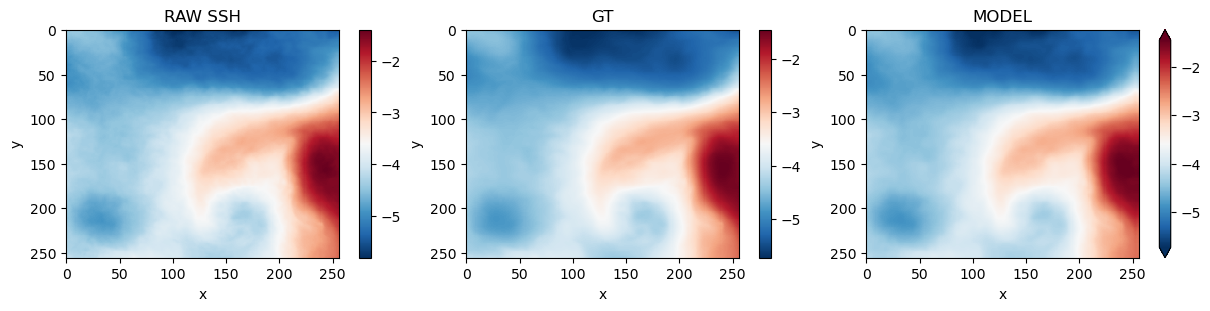

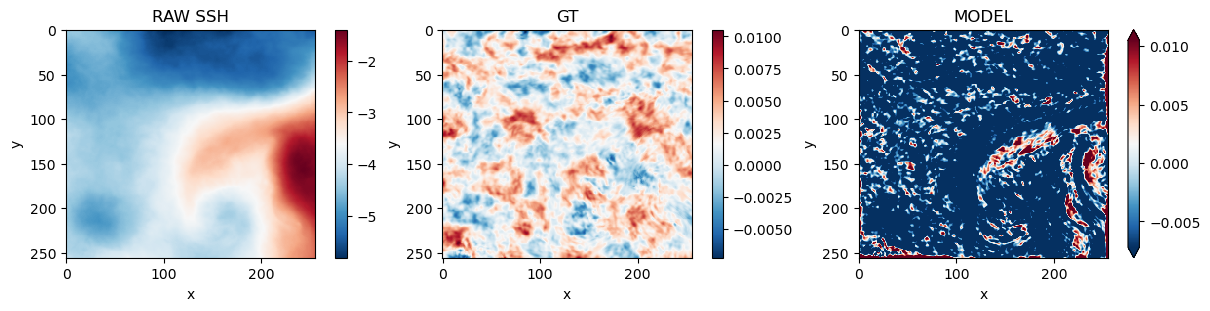

In [37]:
idx = 10
plot_examples(inps[idx], tars1[idx], gens1[idx])
plot_examples(inps[idx], tars2[idx], gens2[idx])

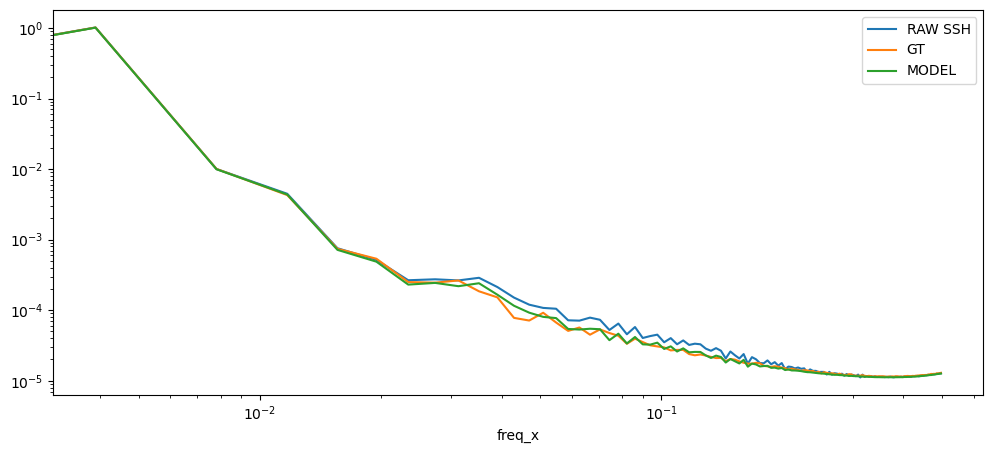

In [38]:
fig, ax = plt.subplots(figsize=(12, 5))

da_rw = xr.DataArray(inps[idx].squeeze(), dims=['x', 'y'])
da_gt = xr.DataArray(tars1[idx].squeeze(), dims=['x', 'y'])
da_gn = xr.DataArray(gens1[idx].squeeze(), dims=['x', 'y'])


ps_rw = xrft.power_spectrum(da_rw, 'x', window='hamming').rename('rw')
ps_gt = xrft.power_spectrum(da_gt, 'x', window='hamming').rename('gt')
ps_gn = xrft.power_spectrum(da_gn, 'x', window='hamming').rename('gn')

(ps_rw * ps_rw.freq_x).mean('y').plot(label='RAW SSH', ax=ax)
(ps_gt * ps_gt.freq_x).mean('y').plot(label='GT', ax=ax)
(ps_gn * ps_gn.freq_x).mean('y').plot(label='MODEL', ax=ax)

plt.xscale('log')
plt.yscale('log')

plt.legend()
plt.show()